In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

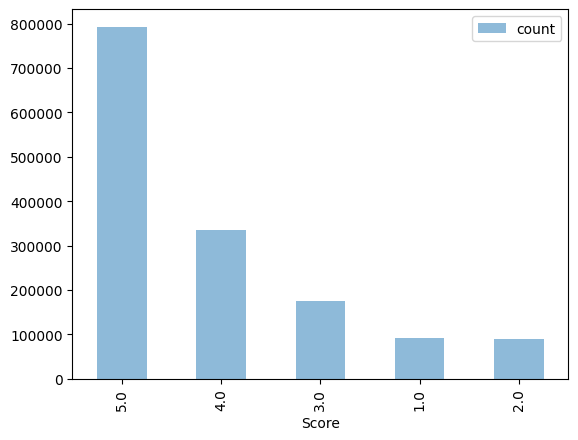


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

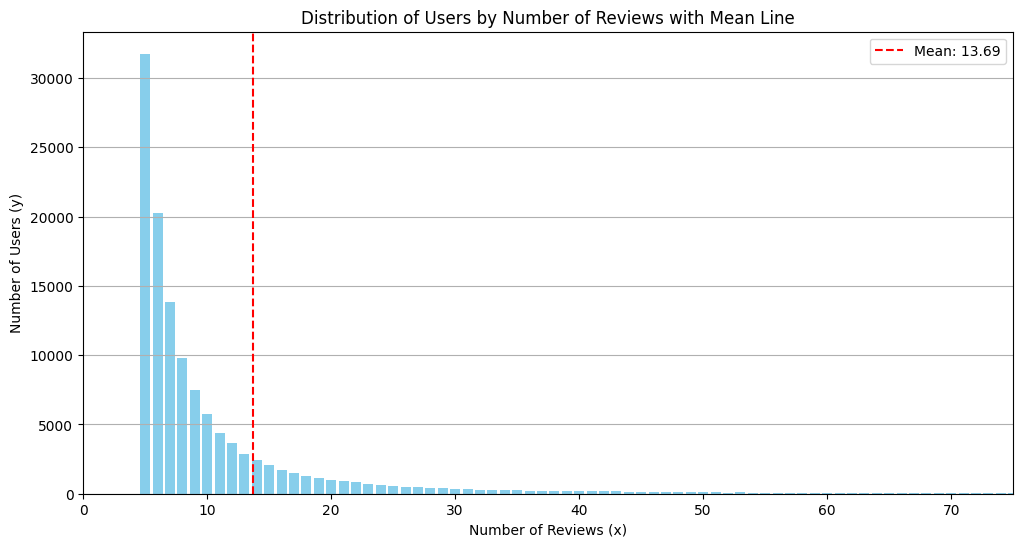

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is your DataFrame and has a column `UserId`

# Count the number of reviews per user
review_counts = trainingSet['UserId'].value_counts().reset_index()
review_counts.columns = ['UserId', 'ReviewCount']

# Count how many users have each review count
review_count_distribution = review_counts['ReviewCount'].value_counts().sort_index()

mean_review_count = review_counts['ReviewCount'].mean()

# Step 3: Plotting the distribution with a vertical line for the mean
plt.figure(figsize=(12, 6))
plt.bar(review_count_distribution.index, review_count_distribution.values, color='skyblue')
plt.axvline(mean_review_count, color='red', linestyle='--', label=f'Mean: {mean_review_count:.2f}')
plt.xlim(0, 75)
# plt.ylim(0, 10)
plt.xlabel('Number of Reviews (x)')
plt.ylabel('Number of Users (y)')
plt.title('Distribution of Users by Number of Reviews with Mean Line')
plt.legend()
plt.grid(axis='y')
plt.show()


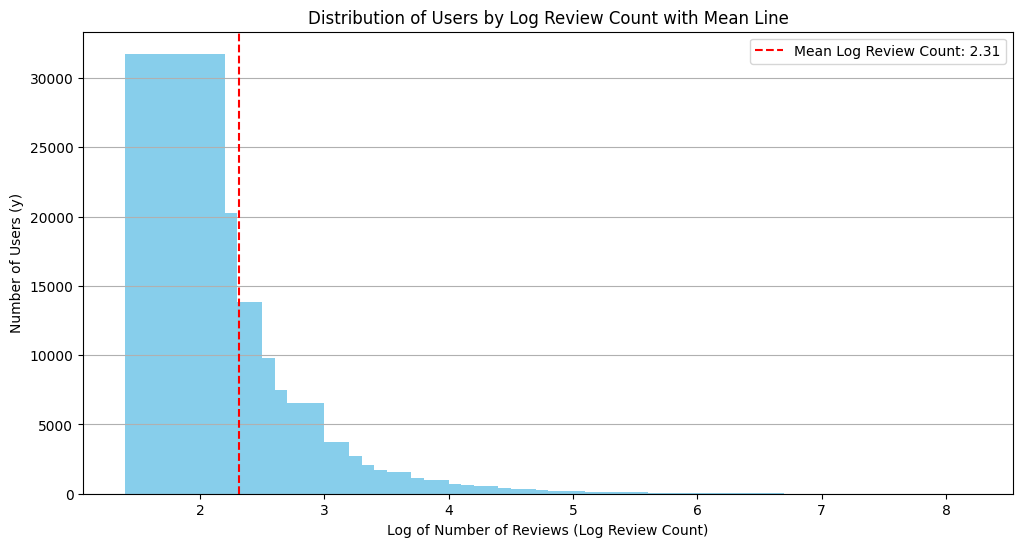

In [16]:
import numpy as np

# Calculate Log Review Count for each user
review_counts['LogReviewCount'] = np.log1p(review_counts['ReviewCount'])  # log1p for log(1 + x)

# Count how many users have each log review count (rounded for clarity in distribution)
log_review_count_distribution = review_counts['LogReviewCount'].round(1).value_counts().sort_index()

# Calculate mean of log review counts for reference
mean_log_review_count = review_counts['LogReviewCount'].mean()

# Plotting the distribution with a vertical line for the mean (log scale)
plt.figure(figsize=(12, 6))
plt.bar(log_review_count_distribution.index, log_review_count_distribution.values, color='skyblue')
plt.axvline(mean_log_review_count, color='red', linestyle='--', label=f'Mean Log Review Count: {mean_log_review_count:.2f}')
plt.xlabel('Log of Number of Reviews (Log Review Count)')
plt.ylabel('Number of Users (y)')
plt.title('Distribution of Users by Log Review Count with Mean Line')
plt.legend()
plt.grid(axis='y')
plt.show()


Correlation between Review Count and Helpfulness Ratio: 0.15291228839405888


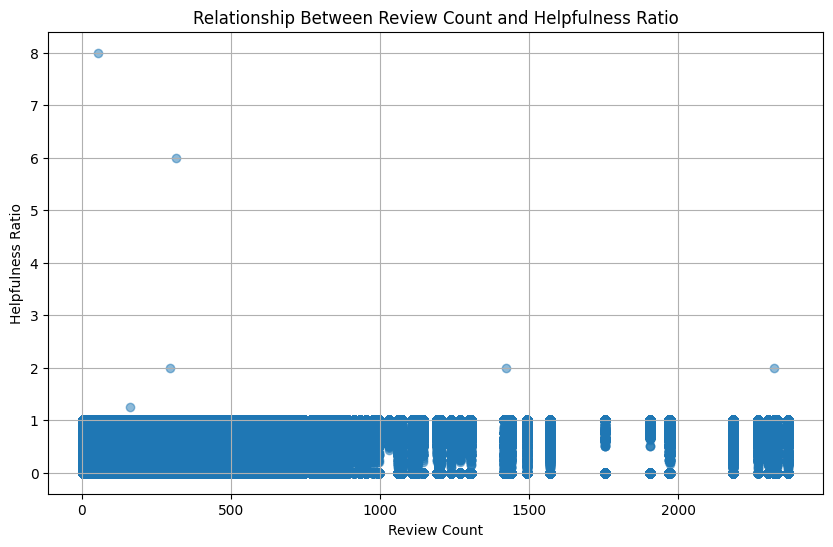

In [17]:
# Calculate Review Count for each user
review_counts = trainingSet['UserId'].value_counts().reset_index()
review_counts.columns = ['UserId', 'ReviewCount']

# Merge Review Count into the main DataFrame
trainingSet = pd.merge(trainingSet, review_counts, on='UserId', how='left')

# Calculate Helpfulness Ratio (HelpfulnessNumerator / HelpfulnessDenominator)
trainingSet['HelpfulnessRatio'] = trainingSet['HelpfulnessNumerator'] / trainingSet['HelpfulnessDenominator']
trainingSet['HelpfulnessRatio'] = trainingSet['HelpfulnessRatio'].fillna(0)  # Fill NaNs with 0 for reviews without votes

# Interaction feature: Review Count * Helpfulness Ratio
trainingSet['ReviewHelpfulnessInteraction'] = trainingSet['ReviewCount'] * trainingSet['HelpfulnessRatio']

trainingSet['LogReviewHelpfulnessInteraction'] = np.log1p(trainingSet['ReviewHelpfulnessInteraction'])

correlation = trainingSet[['ReviewCount', 'HelpfulnessRatio']].corr()
print("Correlation between Review Count and Helpfulness Ratio:", correlation.iloc[0, 1])

import matplotlib.pyplot as plt

# Scatter plot of Review Count vs Helpfulness Ratio
plt.figure(figsize=(10, 6))
plt.scatter(trainingSet['ReviewCount'], trainingSet['HelpfulnessRatio'], alpha=0.5)
plt.xlabel('Review Count')
plt.ylabel('Helpfulness Ratio')
plt.title('Relationship Between Review Count and Helpfulness Ratio')
plt.grid(True)
plt.show()


Not much of a linear relationship between helpfulness and the number of reviews


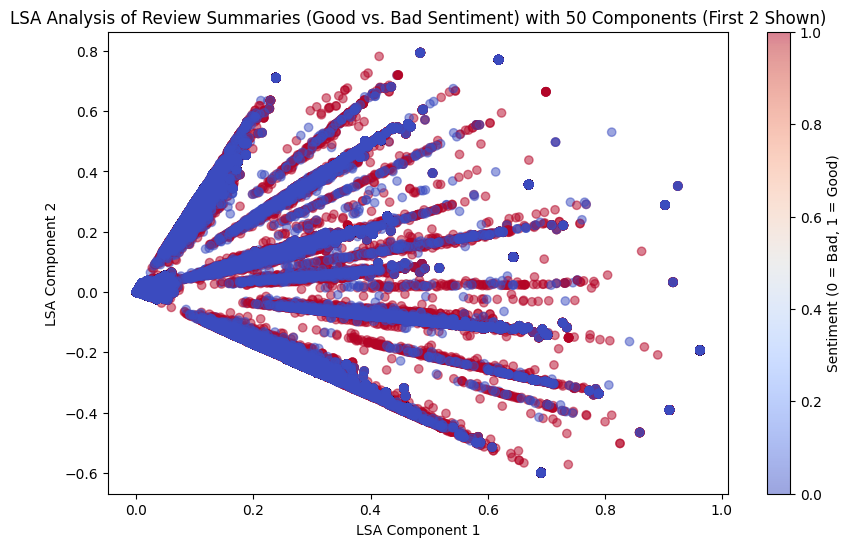

In [28]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Drop rows with missing summaries
trainingSet = trainingSet.dropna(subset=['Summary'])

# Select relevant columns
summaries = trainingSet['Summary']
scores = trainingSet['Score']

# Convert scores to binary sentiment (1 for good, 0 for bad)
trainingSet['Sentiment'] = trainingSet['Score'].apply(lambda x: 1 if x >= 4 else 0)  # 1 = Good, 0 = Bad
sentiment = trainingSet['Sentiment']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(summaries)

# Initialize SVD to reduce dimensionality for visualization
n_components = 50  # Adjust to a higher number if needed
lsa = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Plotting the first two LSA components with more nuanced themes, colored by sentiment
plt.figure(figsize=(10, 6))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=sentiment, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Sentiment (0 = Bad, 1 = Good)')
plt.xlabel('LSA Component 1')
plt.ylabel('LSA Component 2')
plt.title(f'LSA Analysis of Review Summaries (Good vs. Bad Sentiment) with {n_components} Components (First 2 Shown)')
plt.show()


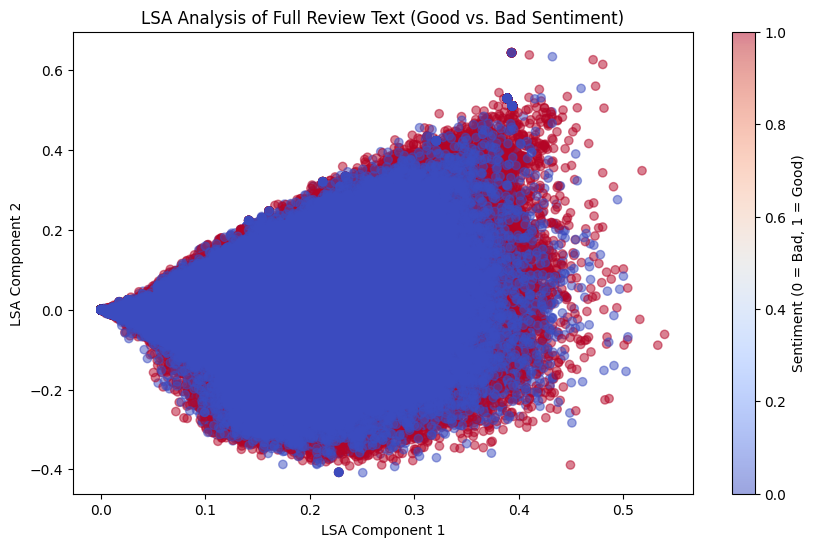

In [27]:
# Import necessary libraries
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Load the train.csv data
# Assuming 'Text' is the column with full review text and 'Score' is used to determine sentiment

# Drop rows with missing text
trainingSet = trainingSet.dropna(subset=['Text'])

# Convert scores to binary sentiment (1 for good, 0 for bad)
trainingSet['Sentiment'] = trainingSet['Score'].apply(lambda x: 1 if x >= 4 else 0)  # 1 = Good, 0 = Bad
sentiment = trainingSet['Sentiment']

# Initialize TF-IDF Vectorizer for the full text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Adjust max_features if necessary
tfidf_matrix = tfidf_vectorizer.fit_transform(trainingSet['Text'])

# Apply SVD on the TF-IDF matrix
n_components = 2  # Number of components to capture
lsa = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Plot the first two LSA components with sentiment coloring
plt.figure(figsize=(10, 6))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=sentiment, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Sentiment (0 = Bad, 1 = Good)')
plt.xlabel('LSA Component 1')
plt.ylabel('LSA Component 2')
plt.title('LSA Analysis of Full Review Text (Good vs. Bad Sentiment)')
plt.show()


In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Load data

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to get sentiment scores
trainingSet['VADER_Sentiment'] = trainingSet['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Classify sentiment based on VADER compound score
# Positive sentiment if compound score > 0, else negative
trainingSet['Predicted_Sentiment'] = trainingSet['VADER_Sentiment'].apply(lambda score: 1 if score > 0 else 0)

# Display the sentiment scores
print(trainingSet[['Text', 'VADER_Sentiment', 'Predicted_Sentiment']].head())


                                                Text  VADER_Sentiment  \
0  While most straight to DVD films are not worth...          -0.6205   
1  I have wanted this one for sometime, also.  I ...           0.4939   
2  Actually this was a pretty darn good indie fil...           0.9733   
3  Episodes 37 to 72 of the series press on in a ...           0.9750   
4  I was really impressed with this movie, but wa...           0.9981   

   Predicted_Sentiment  
0                    0  
1                    1  
2                    1  
3                    1  
4                    1  


In [35]:
print(trainingSet.head())
print(trainingSet.columns)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with you   

                                                Text  S

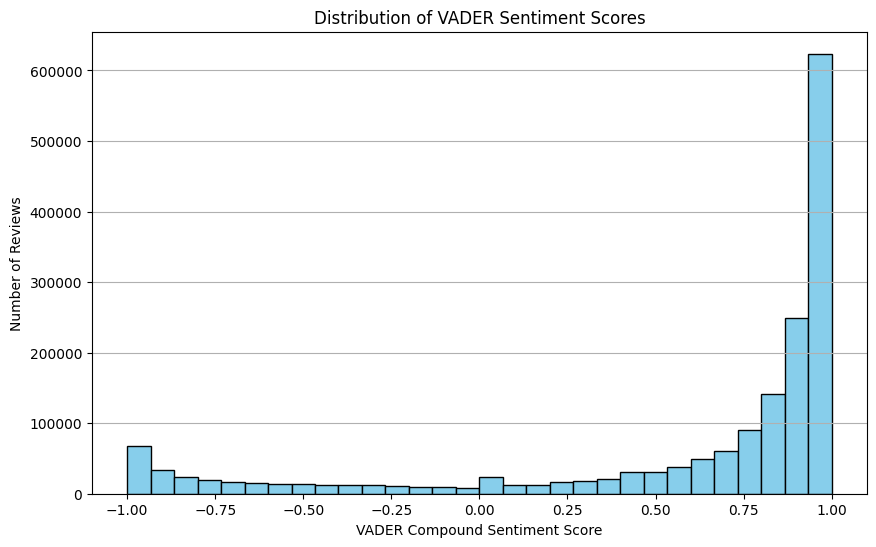

In [32]:
import matplotlib.pyplot as plt

# Plot the VADER sentiment scores for visualization
plt.figure(figsize=(10, 6))
plt.hist(trainingSet['VADER_Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('VADER Compound Sentiment Score')
plt.ylabel('Number of Reviews')
plt.title('Distribution of VADER Sentiment Scores')
plt.grid(axis='y')
plt.show()


Correlation between Review Length and Helpfulness: 0.3070454298708275


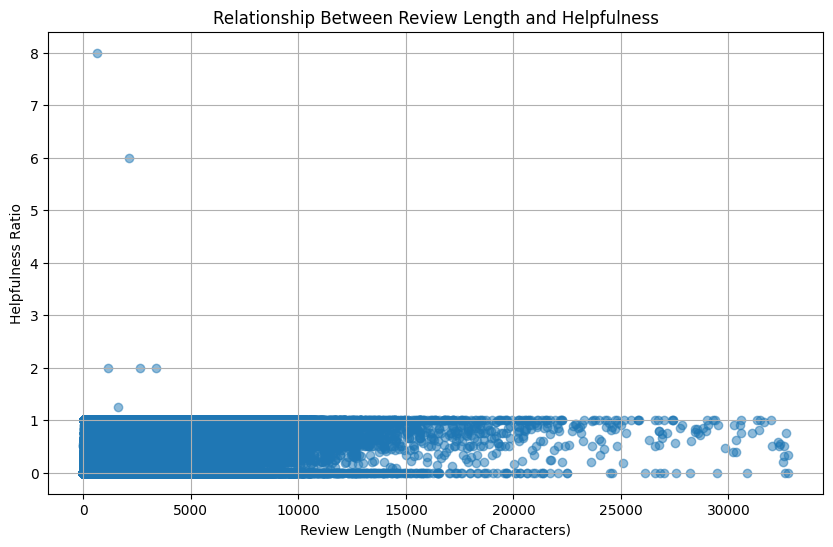

In [37]:
# Ensure 'Review_Length' and 'Helpfulness' features are calculated
trainingSet['Review_Length'] = trainingSet['Text'].apply(len)
trainingSet['Helpfulness'] = trainingSet['HelpfulnessNumerator'] / trainingSet['HelpfulnessDenominator']
trainingSet['Helpfulness'] = trainingSet['Helpfulness'].fillna(0)

# Calculate the correlation
correlation = trainingSet['Review_Length'].corr(trainingSet['Helpfulness'])
print("Correlation between Review Length and Helpfulness:", correlation)



# Plotting the relationship between Review Length and Helpfulness
plt.figure(figsize=(10, 6))
plt.scatter(trainingSet['Review_Length'], trainingSet['Helpfulness'], alpha=0.5)
plt.xlabel("Review Length (Number of Characters)")
plt.ylabel("Helpfulness Ratio")
plt.title("Relationship Between Review Length and Helpfulness")
plt.grid(True)
plt.show()



In [39]:
negative_words = [
    "bad", "poor", "terrible", "disappointing", "awful", "worst", "horrible", "unreliable", "waste", 
    "garbage", "junk", "cheap", "flimsy", "broken", "useless", "defective", "faulty", "fake", "boring",
    "dull", "slow", "overpriced", "lame", "unwatchable", "predictable", "annoying", "inconsistent",
    "ridiculous", "mediocre", "unrealistic", "forgettable", "underwhelming", "unconvincing", "cliché",
    "overrated", "overdone", "painful", "lengthy", "disgusting", "frustrating", "repetitive", "predictable",
    "awkward", "cringe", "stupid", "hated", "inadequate", "pointless", "gross", "unpleasant", "disturbing",
    "misleading", "regret", "boring", "lazy", "dated", "clunky", "dysfunctional", "cheaply-made",
    "underdeveloped", "forgettable", "shallow", "weak", "annoyed", "unpolished", "horrendous", "unappealing",
    "lackluster", "problematic", "flawed", "annoy", "predictable", "cheesy", "cringe", "unbelievable",
    "nonsense", "overblown", "confusing", "shoddy", "stiff", "exaggerated", "excessive", "worthless",
    "unacceptable", "pathetic", "crappy", "sucks", "sucked", "shit", "bullshit", "crap", "damn", "damned",
    "fucking", "fuck", "hell", "pissed", "ass", "bastard", "idiot", "idiotic", "dumb", "moron", "trash",
    "shitty", "fucked", "loser", "garbage", "pathetic", "disgusted", "repulsive", "abysmal", "horrid",
    "gross", "foul", "atrocious", "miserable", "deplorable", "scam", "rip-off", "useless", "failure"
]


In [41]:
trainingSet['Negative_Word_Count'] = trainingSet['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negative_words))
import matplotlib.pyplot as plt

# Plot the distribution of Negative_Word_Count


KeyboardInterrupt: 

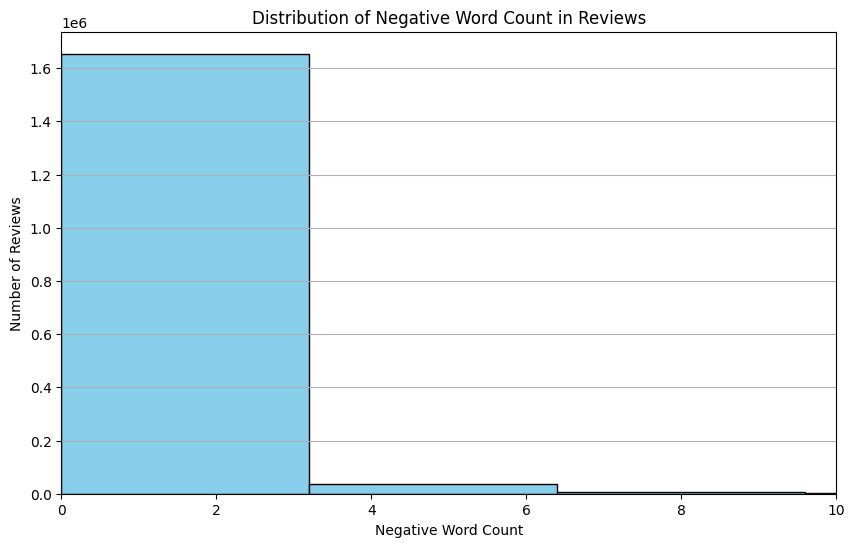

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(trainingSet['Negative_Word_Count'], bins=30, color='skyblue', edgecolor='black')
plt.xlim(0,10)
plt.xlabel("Negative Word Count")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Negative Word Count in Reviews")
plt.grid(axis='y')
plt.show()